Nhóm sinh viên:
- Đỗ Quang Lực - 23520902
- Nguyễn Văn Hồng Thái - 23521418
- Nguyễn Phạm Phương Nam - 23520978

## **Data  preprocessing**
Tiếp nối notebook cho  phần data validation, notebook này trình bày về bước Data preprocessing cho bộ dữ liệu -  bước không thể thiếu nhằm chuẩn hóa và chuẩn bị dữ liệu ở định dạng tối ưu cho việc huấn luyện mô hình. 

Phần này sẽ lần lượt thực hiện các nội dung sau:
- Các chiến lược xử lý dữ liệu NULL
- Các chiến lược xử lý dữ liệu outlier
- Chuẩn hoá dữ liệu
- Các chiến lược encoding

## Thêm các thư viện cần thiết

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler

## Đọc dữ liệu đầu vào

In [2]:
train_df = pd.read_csv('./data/sales_train.csv')
test_df = pd.read_csv('./data/sales_test.csv')
calendar_df = pd.read_csv('./data/calendar.csv')
inventory_df = pd.read_csv('./data/inventory.csv')
weights_df = pd.read_csv('./data/test_weights.csv')

In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4007419 entries, 0 to 4007418
Data columns (total 14 columns):
 #   Column           Dtype  
---  ------           -----  
 0   unique_id        int64  
 1   date             object 
 2   warehouse        object 
 3   total_orders     float64
 4   sales            float64
 5   sell_price_main  float64
 6   availability     float64
 7   type_0_discount  float64
 8   type_1_discount  float64
 9   type_2_discount  float64
 10  type_3_discount  float64
 11  type_4_discount  float64
 12  type_5_discount  float64
 13  type_6_discount  float64
dtypes: float64(11), int64(1), object(2)
memory usage: 428.0+ MB


In [4]:
test_columns = list(test_df.columns)
keep_columns =  list(train_df.columns)
print(test_columns)
keep_columns # Các cột ta cần giữ lại sau khi tiền xử lí dữ liệu

['unique_id', 'date', 'warehouse', 'total_orders', 'sell_price_main', 'type_0_discount', 'type_1_discount', 'type_2_discount', 'type_3_discount', 'type_4_discount', 'type_5_discount', 'type_6_discount']


['unique_id',
 'date',
 'warehouse',
 'total_orders',
 'sales',
 'sell_price_main',
 'availability',
 'type_0_discount',
 'type_1_discount',
 'type_2_discount',
 'type_3_discount',
 'type_4_discount',
 'type_5_discount',
 'type_6_discount']

Trước hết, ta tiến hành kết hợp các bảng dữ liệu lại với nhau

In [5]:
# Gộp sales_train với calendar_df, xử lí holiday
train_df = train_df.merge(calendar_df, on=['date', 'warehouse'], how='left')
# Gộp sales_test với calendar_df, xử lí holiday
test_df = test_df.merge(calendar_df, on=['date', 'warehouse'], how='left')

# Định dạng lại format date
calendar_df['date'] = pd.to_datetime(calendar_df['date'])
train_df['date'] = pd.to_datetime(train_df['date'])
test_df['date'] = pd.to_datetime(test_df['date'])

# Merge sales_train with inventory_df
train_df = train_df.merge(inventory_df, on=['unique_id', 'warehouse'], how='left')
# Merge sales_test with inventory_df
test_df = test_df.merge(inventory_df, on=['unique_id', 'warehouse'], how='left')


# Merge sales_test with test_weights
test_df = test_df.merge(weights_df, on='unique_id', how='left')
#Merge sales_train with test_weights
train_df = train_df.merge(weights_df, on='unique_id', how='left')

In [6]:
print("Number of unique day:",train_df['date'].nunique())
train_df.head()

Number of unique day: 1402


,unique_id,date,warehouse,total_orders,sales,sell_price_main,availability,type_0_discount,type_1_discount,type_2_discount,...,shops_closed,winter_school_holidays,school_holidays,product_unique_id,name,L1_category_name_en,L2_category_name_en,L3_category_name_en,L4_category_name_en,weight
0,4845,2024-03-10,Budapest_1,6436.0,16.34,646.26,1.00,0.00000,0.0,0.0,...,0,0,0,2375,Croissant_35,Bakery,Bakery_L2_18,Bakery_L3_83,Bakery_L4_1,1.925596
1,4845,2021-05-25,Budapest_1,4663.0,12.63,455.96,1.00,0.00000,0.0,0.0,...,0,0,0,2375,Croissant_35,Bakery,Bakery_L2_18,Bakery_L3_83,Bakery_L4_1,1.925596
2,4845,2021-12-20,Budapest_1,6507.0,34.55,455.96,1.00,0.00000,0.0,0.0,...,0,0,0,2375,Croissant_35,Bakery,Bakery_L2_18,Bakery_L3_83,Bakery_L4_1,1.925596
3,4845,2023-04-29,Budapest_1,5463.0,34.52,646.26,0.96,0.20024,0.0,0.0,...,0,0,0,2375,Croissant_35,Bakery,Bakery_L2_18,Bakery_L3_83,Bakery_L4_1,1.925596
4,4845,2022-04-01,Budapest_1,5997.0,35.92,486.41,1.00,0.00000,0.0,0.0,...,0,0,0,2375,Croissant_35,Bakery,Bakery_L2_18,Bakery_L3_83,Bakery_L4_1,1.925596


In [7]:
print(f"Shape")
print(f"train: {train_df.shape}")
print(f"test: {test_df.shape}")

Shape
train: (4007419, 26)
test: (47021, 24)


## 1. Xử lí dữ liệu NULL

In [8]:
train_df.isnull().sum()

unique_id                       0
date                            0
warehouse                       0
total_orders                   52
sales                          52
sell_price_main                 0
availability                    0
type_0_discount                 0
type_1_discount                 0
type_2_discount                 0
type_3_discount                 0
type_4_discount                 0
type_5_discount                 0
type_6_discount                 0
holiday_name              3844119
holiday                         0
shops_closed                    0
winter_school_holidays          0
school_holidays                 0
product_unique_id               0
name                            0
L1_category_name_en             0
L2_category_name_en             0
L3_category_name_en             0
L4_category_name_en             0
weight                          0
dtype: int64

Vì có rất nhiều ngày không phải là ngày lễ, nên số lượng ngày có holyday_name = NULL lớn là bình thường

Vì bộ dữ liệu lớn, với 52 dòng có total_orders và sales null, ta có thể tiến hành drop mà không ảnh hưởng quá nhiều.

In [9]:
train_df = train_df.dropna(subset=['sales'])
train_df.isnull().sum()

unique_id                       0
date                            0
warehouse                       0
total_orders                    0
sales                           0
sell_price_main                 0
availability                    0
type_0_discount                 0
type_1_discount                 0
type_2_discount                 0
type_3_discount                 0
type_4_discount                 0
type_5_discount                 0
type_6_discount                 0
holiday_name              3844077
holiday                         0
shops_closed                    0
winter_school_holidays          0
school_holidays                 0
product_unique_id               0
name                            0
L1_category_name_en             0
L2_category_name_en             0
L3_category_name_en             0
L4_category_name_en             0
weight                          0
dtype: int64

Ta điền những ngày lễ bị miss để đảm bảo tính nhất quán

In [10]:
train_df['holiday_name'] = train_df['holiday_name'].fillna("N/A")
test_df['holiday_name'] = test_df['holiday_name'].fillna("N/A")

# Ensure holiday names in train and test are from the same set
common_holidays = set(train_df['holiday_name'].unique()).intersection(set(test_df['holiday_name'].unique()))

# Replace unknown holidays with "N/A" in train and test
train_df['holiday_name'] = train_df['holiday_name'].apply(lambda x: x if x in common_holidays else "N/A")
test_df['holiday_name'] = test_df['holiday_name'].apply(lambda x: x if x in common_holidays else "N/A")

## 2. Xử lí dữ liệu Outlier

Ở log sales histogram trong bước EDA, ta thấy có 1 lượng lớn điểm dữ liệu có sales = 0, và một số điểm dữ liệu có sales lớn bất thường (có thể là do vào các dịp lễ nên nhu cầu mua lớn, hoặc dữ liệu bị lỗi), các điểm này ảnh hưởng đến việc học của mô hình nên ta loại bỏ khỏi tập dữ liệu

Ta sử dụng IQR để tìm ra các điểm dữ liệu được cho là Outlier và loại bỏ chúng.

In [11]:
Q1 = np.log1p(train_df["sales"]).quantile(0.25)
Q3 = np.log1p(train_df["sales"]).quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

train_df = train_df[(np.log1p(train_df["sales"]) >= lower) & (np.log1p(train_df["sales"]) <= upper)]

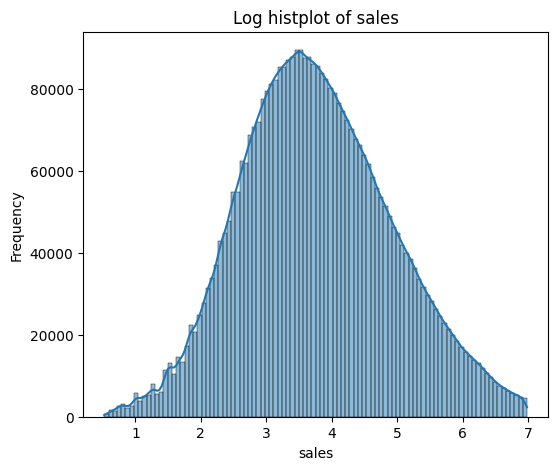

In [12]:
plt.figure(figsize=(6, 5))

sns.histplot(x=np.log1p(train_df['sales']), bins=100, kde=True)

plt.title(f'Log histplot of sales')
plt.xlabel('sales')
plt.ylabel('Frequency')

plt.show()

Ở bước EDA, ta thấy có 1 vài điểm dữ liệu bất thường ở các loại giảm giá khác nhau được áp dụng bởi Rohlik. Và vì giá trị âm nghĩa là **không có giảm giá** nên ta sẽ đưa các giá trị  đó về 0

In [13]:
train_df.loc[train_df['type_0_discount'] < 0, 'type_0_discount'] = 0
train_df.loc[train_df['type_4_discount'] < 0, 'type_4_discount'] = 0
train_df.loc[train_df['type_6_discount'] < 0, 'type_6_discount'] = 0

## 3. Chuẩn hóa dữ liệu

Quan sát dữ liệu ban đầu, ta thấy các cột đặc trưng có sự chênh lệch lớn về đơn vị và thang đo

Ví dụ: 
- Cột `total_orders` có giá trị ở hàng nghìn (ví dụ: 6436.0).
- Các cột như `availability`, `type_X_discount` chỉ nằm trong khoảng từ $0$ đến $1$. 
- sell_price_main cũng nằm ở những thang đo khác, có thể ảnh hưởng đến mô hình nếu không được xử lý.

Ta sử dụng `StandardScaler` để chuẩn hoá các đặc trưng, đưa dữ liệu về phân phối chuẩn (mean = 0, std = 1). Các cột được chuẩn hoá bao gồm:
- `total_orders`
- `sell_price_main`

In [14]:
from sklearn.preprocessing import MinMaxScaler
cols_to_scale = ['total_orders', 'sell_price_main']

scaler = MinMaxScaler()
train_df[cols_to_scale] = scaler.fit_transform(train_df[cols_to_scale])

In [15]:
train_df.head()

,unique_id,date,warehouse,total_orders,sales,sell_price_main,availability,type_0_discount,type_1_discount,type_2_discount,...,shops_closed,winter_school_holidays,school_holidays,product_unique_id,name,L1_category_name_en,L2_category_name_en,L3_category_name_en,L4_category_name_en,weight
0,4845,2024-03-10,Budapest_1,0.331575,16.34,0.048762,1.00,0.00000,0.0,0.0,...,0,0,0,2375,Croissant_35,Bakery,Bakery_L2_18,Bakery_L3_83,Bakery_L4_1,1.925596
1,4845,2021-05-25,Budapest_1,0.233135,12.63,0.034403,1.00,0.00000,0.0,0.0,...,0,0,0,2375,Croissant_35,Bakery,Bakery_L2_18,Bakery_L3_83,Bakery_L4_1,1.925596
2,4845,2021-12-20,Budapest_1,0.335517,34.55,0.034403,1.00,0.00000,0.0,0.0,...,0,0,0,2375,Croissant_35,Bakery,Bakery_L2_18,Bakery_L3_83,Bakery_L4_1,1.925596
3,4845,2023-04-29,Budapest_1,0.277553,34.52,0.048762,0.96,0.20024,0.0,0.0,...,0,0,0,2375,Croissant_35,Bakery,Bakery_L2_18,Bakery_L3_83,Bakery_L4_1,1.925596
4,4845,2022-04-01,Budapest_1,0.307201,35.92,0.036701,1.00,0.00000,0.0,0.0,...,0,0,0,2375,Croissant_35,Bakery,Bakery_L2_18,Bakery_L3_83,Bakery_L4_1,1.925596


## 4. Encoding

Trong tập dữ liệu, cột `warehouse` đại diện cho tên kho hàng nơi sản phẩm được phân phối. Mỗi kho có những yếu tố khác nhau (quy mô khách hàng, nhu cầu tiêu dùng,...) có thể tác động trực tiếp đến doanh số. Ta có thể thấy rõ điều đó trên biểu đồ Phân phối doanh thu theo từng kho (histogram) ở bước EDA.

Vì `warehouse` là một biến categorical, và số lượng cũng không quá lớn (7 kho) nên ta cần mã hóa bằng one-hot encoding:

In [16]:
keep_columns.remove('warehouse')
for wh in train_df['warehouse'].unique():
    print('wh_' + wh)
    keep_columns.append('wh_' + wh)

train_df = pd.get_dummies(train_df, columns=['warehouse'], prefix='wh', drop_first=False)

wh_Budapest_1
wh_Prague_2
wh_Brno_1
wh_Prague_1
wh_Prague_3
wh_Munich_1
wh_Frankfurt_1


In [17]:
train_df.head()

,unique_id,date,total_orders,sales,sell_price_main,availability,type_0_discount,type_1_discount,type_2_discount,type_3_discount,...,L3_category_name_en,L4_category_name_en,weight,wh_Brno_1,wh_Budapest_1,wh_Frankfurt_1,wh_Munich_1,wh_Prague_1,wh_Prague_2,wh_Prague_3
0,4845,2024-03-10,0.331575,16.34,0.048762,1.00,0.00000,0.0,0.0,0.0,...,Bakery_L3_83,Bakery_L4_1,1.925596,False,True,False,False,False,False,False
1,4845,2021-05-25,0.233135,12.63,0.034403,1.00,0.00000,0.0,0.0,0.0,...,Bakery_L3_83,Bakery_L4_1,1.925596,False,True,False,False,False,False,False
2,4845,2021-12-20,0.335517,34.55,0.034403,1.00,0.00000,0.0,0.0,0.0,...,Bakery_L3_83,Bakery_L4_1,1.925596,False,True,False,False,False,False,False
3,4845,2023-04-29,0.277553,34.52,0.048762,0.96,0.20024,0.0,0.0,0.0,...,Bakery_L3_83,Bakery_L4_1,1.925596,False,True,False,False,False,False,False
4,4845,2022-04-01,0.307201,35.92,0.036701,1.00,0.00000,0.0,0.0,0.0,...,Bakery_L3_83,Bakery_L4_1,1.925596,False,True,False,False,False,False,False


# Feature Extraction

Ở phần này chúng ta sẽ có các chiến thuật Tạo mới đặc trưng mới, biến đổi đặc trưng, làm phong phú hơn các đặc trưng cũng như loại bỏ các đặc trưng không có nhiều tác động đến mô hình

Ta sử dụng các chiến thuật sau:
- Tạo thêm các đặc trưng 
- Tìm ra các đặc trưng quan trọng đối với mô hình

## 1. Tạo thêm các đặc trưng

Để có thể đoán được doanh thu trong tương lai dựa trên dữ liệu quá khứ, ta tạo thêm cột tính tổng doanh thu (sales) và tổng order(total_orders) được nhóm theo `L1_category_name_en` 

In [18]:
# Total and average sales per category
category_sales = train_df.groupby('L1_category_name_en')['sales'].agg(['sum', 'mean']).reset_index()
category_sales.rename(columns={'sum': 'category_sales_sum', 'mean': 'category_sales_avg'}, inplace=True)
# Merge into training and test datasets
train_df = train_df.merge(category_sales, on='L1_category_name_en', how='left')
test_df = test_df.merge(category_sales, on='L1_category_name_en', how='left')

# Convert date to datetime and extract components
for df in [train_df, test_df]:
    df['date'] = pd.to_datetime(df['date'])
    df['month'] = df['date'].dt.month
    df['day_of_week'] = df['date'].dt.dayofweek
    df['week_of_year'] = df['date'].dt.isocalendar().week

# 1.Total and average orders per category
cat_order_stats = train_df.groupby('L1_category_name_en')['total_orders'].agg(['sum','mean']).reset_index()
cat_order_stats.rename(columns={'sum': 'category_orders_sum', 'mean': 'category_orders_avg'}, inplace=True)

# 2. Merge các chỉ số này vào train_df
train_df = train_df.merge(cat_order_stats,
                          on='L1_category_name_en',
                          how='left')

# 3. Merge các chỉ số này vào test_df
test_df = test_df.merge(cat_order_stats,
                        on='L1_category_name_en',
                        how='left')

Thông thường ở các cửa hàng có giảm giá thì sẽ có nhiều người mua hơn. Ta sẽ thêm một đặc trưng mới là tổng phần trăm discount của tất cả các loại discount.

In [19]:
# Calculate the total discount applied in Sales_Train
discount_columns = [f'type_{i}_discount' for i in range(7)]
train_df['total_discount'] = train_df[discount_columns].sum(axis=1)
# Calculate the total discount applied in Sales_Test
discount_columns_test = [f'type_{i}_discount' for i in range(7)]
test_df['total_discount'] = train_df[discount_columns_test].sum(axis=1)

Giữ lại các cột cần thiết

In [20]:
keep_columns.append('category_sales_sum')
keep_columns.append('category_sales_avg')
keep_columns.append('category_orders_sum')
keep_columns.append('category_orders_avg')
keep_columns.append('total_discount')
keep_columns.append('L1_category_name_en')
train_df = train_df[keep_columns]
train_df.columns

Index(['unique_id', 'date', 'total_orders', 'sales', 'sell_price_main',
       'availability', 'type_0_discount', 'type_1_discount', 'type_2_discount',
       'type_3_discount', 'type_4_discount', 'type_5_discount',
       'type_6_discount', 'wh_Budapest_1', 'wh_Prague_2', 'wh_Brno_1',
       'wh_Prague_1', 'wh_Prague_3', 'wh_Munich_1', 'wh_Frankfurt_1',
       'category_sales_sum', 'category_sales_avg', 'category_orders_sum',
       'category_orders_avg', 'total_discount', 'L1_category_name_en'],
      dtype='object')

Scale lại các đặc trưng vừa thêm

In [21]:
cols_to_scale = ['category_sales_sum', 'category_sales_avg']

scaler = MinMaxScaler()
train_df[cols_to_scale] = scaler.fit_transform(train_df[cols_to_scale])

## 2. Tìm ra các đặc trưng quan trọng đối với mô hình

Ta thêm 1 cột random_noise để biểu diễn 1 đặc trưng không có ý nghĩa đối với dữ  liệu, sau đó sử dụng **Lasso** để tìm ra hệ số alpha tương ứng đối với `random_noise`. Các đặc trưng có trị tuyệt đổi của hệ số lớn hơn trị tuyệt đối hệ số của `random_noise` sẽ là những đặc trưng quan trọng.

In [22]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import Lasso
np.random.seed(42)
train_df['random_noise'] = np.random.normal(0, 1, size=len(train_df))

# 2. Mã hóa và chuyển đổi date
le = LabelEncoder()
train_df['L1_category_name_en'] = le.fit_transform(train_df['L1_category_name_en'])

train_df['date'] = pd.to_datetime(train_df['date'])
train_df['date'] = (train_df['date'] - train_df['date'].min()).dt.days

X = train_df.drop(columns=['sales']).copy()
y = train_df['sales'].copy()

# 5. Chuẩn hóa
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_columns = X.columns

# 6. Huấn luyện Lasso
lasso = Lasso(alpha=0.01, random_state=42, max_iter=5000)
lasso.fit(X_scaled, y)

# 7. Lấy hệ số và chọn feature quan trọng hơn noise
coef = pd.Series(lasso.coef_, index=X_columns)
noise_coef = coef.get('random_noise', 0)
important_features = coef[coef.abs() > abs(noise_coef)].drop('random_noise', errors='ignore').sort_values(ascending=False)

important_features

total_orders           30.583972
type_0_discount        30.418815
wh_Budapest_1          12.961777
wh_Munich_1            11.213021
type_2_discount        10.456292
category_sales_sum      8.806143
wh_Frankfurt_1          4.637787
category_sales_avg      2.682386
type_5_discount         2.212226
type_4_discount         2.122602
availability            1.433763
type_1_discount         1.280877
type_3_discount         0.974666
category_orders_sum     0.152952
wh_Brno_1               0.040824
unique_id              -0.140600
wh_Prague_2            -2.182078
wh_Prague_3            -2.217350
category_orders_avg    -2.933563
wh_Prague_1            -5.625611
type_6_discount        -5.945918
date                  -11.645200
sell_price_main       -14.019986
dtype: float64

In [23]:
# Chỉ giữ lại các cột quan trọng
keep_columns = important_features.index.tolist() + ['sales']
train_df = train_df[keep_columns]
train_df

,total_orders,type_0_discount,wh_Budapest_1,wh_Munich_1,type_2_discount,category_sales_sum,wh_Frankfurt_1,category_sales_avg,type_5_discount,type_4_discount,...,wh_Brno_1,unique_id,wh_Prague_2,wh_Prague_3,category_orders_avg,wh_Prague_1,type_6_discount,date,sell_price_main,sales
0,0.331575,0.00000,True,False,0.0,0.519163,False,0.631311,0.0,0.15312,...,False,4845,False,False,0.307239,False,0.0,1317,0.048762,16.34
1,0.233135,0.00000,True,False,0.0,0.519163,False,0.631311,0.0,0.15025,...,False,4845,False,False,0.307239,False,0.0,297,0.034403,12.63
2,0.335517,0.00000,True,False,0.0,0.519163,False,0.631311,0.0,0.15025,...,False,4845,False,False,0.307239,False,0.0,506,0.034403,34.55
3,0.277553,0.20024,True,False,0.0,0.519163,False,0.631311,0.0,0.15312,...,False,4845,False,False,0.307239,False,0.0,1001,0.048762,34.52
4,0.307201,0.00000,True,False,0.0,0.519163,False,0.631311,0.0,0.15649,...,False,4845,False,False,0.307239,False,0.0,608,0.036701,35.92
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3915367,0.528788,0.00000,False,False,0.0,1.000000,False,1.000000,0.0,0.00000,...,False,4941,False,False,0.302525,True,0.0,1054,0.002568,26.56
3915368,0.447171,0.00000,False,False,0.0,1.000000,False,1.000000,0.0,0.00000,...,False,4941,False,False,0.302525,True,0.0,1057,0.002568,27.42
3915369,0.552995,0.00000,False,False,0.0,1.000000,False,1.000000,0.0,0.00000,...,False,4941,False,False,0.302525,True,0.0,1056,0.002568,33.39
3915370,0.548443,0.00000,False,False,0.0,1.000000,False,1.000000,0.0,0.00000,...,False,4941,False,False,0.302525,True,0.0,1055,0.002568,22.88


Chọn lựa đặc trưng bằng các phương pháp:
- Dựa vào correlation matrix (ma trận tương quan).

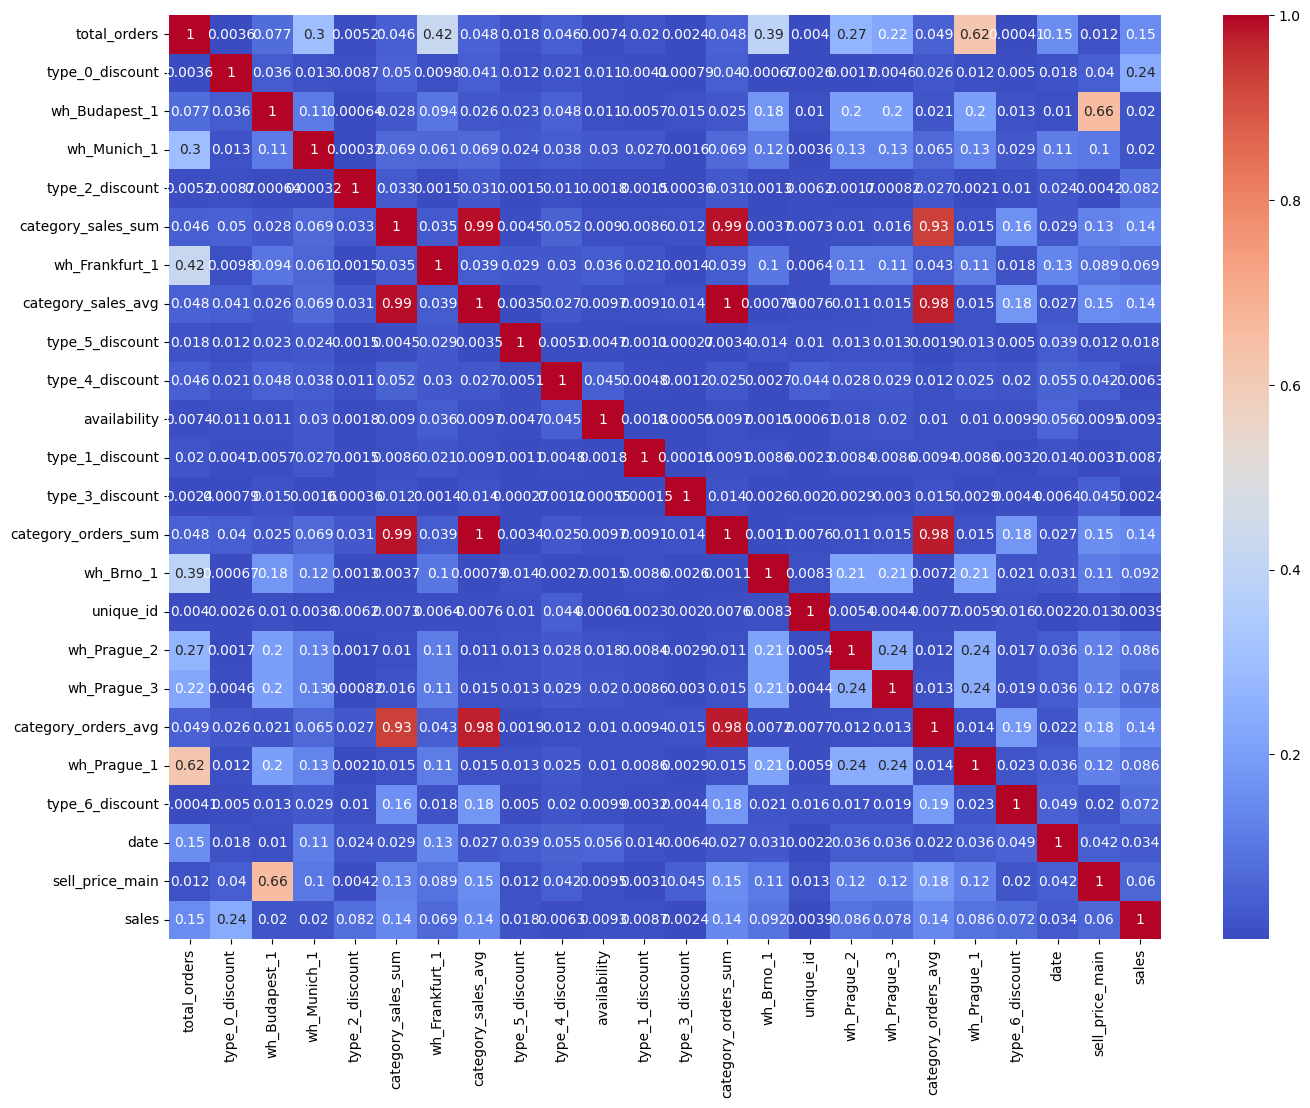

In [24]:
plt.figure(figsize=(16, 12))
corr_matrix = train_df.corr(numeric_only=True).abs()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

In [25]:
corr_matrix = train_df.corr(numeric_only=True).abs()

# Lấy upper triangle của ma trận (vì ma trận đối xứng)
upper = corr_matrix.where(
    pd.DataFrame(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool), 
                 columns=corr_matrix.columns, index=corr_matrix.index)
)

# Tìm các cột có tương quan > 0.90
to_drop = [column for column in upper.columns if any(upper[column] > 0.90)]
to_drop
# Loại bỏ chúng khỏi DataFrame
train_df = train_df.drop(columns=to_drop)
train_df

,total_orders,type_0_discount,wh_Budapest_1,wh_Munich_1,type_2_discount,category_sales_sum,wh_Frankfurt_1,type_5_discount,type_4_discount,availability,...,type_3_discount,wh_Brno_1,unique_id,wh_Prague_2,wh_Prague_3,wh_Prague_1,type_6_discount,date,sell_price_main,sales
0,0.331575,0.00000,True,False,0.0,0.519163,False,0.0,0.15312,1.00,...,0.0,False,4845,False,False,False,0.0,1317,0.048762,16.34
1,0.233135,0.00000,True,False,0.0,0.519163,False,0.0,0.15025,1.00,...,0.0,False,4845,False,False,False,0.0,297,0.034403,12.63
2,0.335517,0.00000,True,False,0.0,0.519163,False,0.0,0.15025,1.00,...,0.0,False,4845,False,False,False,0.0,506,0.034403,34.55
3,0.277553,0.20024,True,False,0.0,0.519163,False,0.0,0.15312,0.96,...,0.0,False,4845,False,False,False,0.0,1001,0.048762,34.52
4,0.307201,0.00000,True,False,0.0,0.519163,False,0.0,0.15649,1.00,...,0.0,False,4845,False,False,False,0.0,608,0.036701,35.92
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3915367,0.528788,0.00000,False,False,0.0,1.000000,False,0.0,0.00000,1.00,...,0.0,False,4941,False,False,True,0.0,1054,0.002568,26.56
3915368,0.447171,0.00000,False,False,0.0,1.000000,False,0.0,0.00000,1.00,...,0.0,False,4941,False,False,True,0.0,1057,0.002568,27.42
3915369,0.552995,0.00000,False,False,0.0,1.000000,False,0.0,0.00000,1.00,...,0.0,False,4941,False,False,True,0.0,1056,0.002568,33.39
3915370,0.548443,0.00000,False,False,0.0,1.000000,False,0.0,0.00000,1.00,...,0.0,False,4941,False,False,True,0.0,1055,0.002568,22.88


In [28]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3915372 entries, 0 to 3915371
Data columns (total 21 columns):
 #   Column              Dtype  
---  ------              -----  
 0   total_orders        float64
 1   type_0_discount     float64
 2   wh_Budapest_1       bool   
 3   wh_Munich_1         bool   
 4   type_2_discount     float64
 5   category_sales_sum  float64
 6   wh_Frankfurt_1      bool   
 7   type_5_discount     float64
 8   type_4_discount     float64
 9   availability        float64
 10  type_1_discount     float64
 11  type_3_discount     float64
 12  wh_Brno_1           bool   
 13  unique_id           int64  
 14  wh_Prague_2         bool   
 15  wh_Prague_3         bool   
 16  wh_Prague_1         bool   
 17  type_6_discount     float64
 18  date                int64  
 19  sell_price_main     float64
 20  sales               float64
dtypes: bool(7), float64(12), int64(2)
memory usage: 444.3 MB
